# Setup and Preprocessing

## Load code and data

In [1]:
## import code
# basics and plotting
import re
import pandas as pd
import numpy as np
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# preprocessing
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# cross validation and modeling
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PoissonRegressor
from xgboost import XGBRegressor
from xgboost import XGBClassifier

# tuning
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.model_selection import validation_curve

# staticial comparison of model performance
# see https://github.com/janezd/baycomp
# to install library:
# pip install baycomp
from baycomp.single import two_on_single

# feature importance
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

In [2]:
# load preprocessed data set into a dataframe
data = pd.read_csv('data_preproc.csv')

# XGBoost Comparison

## nssi_bin

In [3]:
# define target
target = data['nssi_bin']

# define features
features = data[['loneliness', 'depression', 'sex', 'gender', 'orientation', 'behav_act',
                   'hope', 'hopelessness', 'child_adverse', 'peer_vict', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define imputer
imputer = KNNImputer(n_neighbors=5)

# define cross validation procedure
cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=0)

### Logistic regression model

In [4]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [5]:
# define algorithm
logreg = LogisticRegression(class_weight='balanced', random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, logreg)

In [6]:
# set C to 0.1
pipeline.set_params(logisticregression__C=0.1)

# get results from tuned model
logreg_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_accuracy"].mean():.3f} +/- {logreg_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{logreg_results["test_precision"].mean():.3f} +/- {logreg_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{logreg_results["test_recall"].mean():.3f} +/- {logreg_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.690 +/- 0.030
The mean precision with cross-validation is: 0.822 +/- 0.025
The mean recall with cross-validation is: 0.690 +/- 0.034
The mean AUROC with cross-validation is: 0.750 +/- 0.033


### XGBoost model

In [7]:
# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

# define algorithm
class_weighting = target.value_counts()[0] / target.value_counts()[1]
xgbc = XGBClassifier(learning_rate=0.1, n_jobs=2, scale_pos_weight=class_weighting, random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, xgbc)

In [8]:
# hyperparameter values to try
param_grid =  {
    'xgbclassifier__max_leaves': [4, 8, 16, 32, 64, 128],
    'xgbclassifier__reg_lambda': [0.1, 0.5, 1, 2, 5, 10],
    'xgbclassifier__n_estimators': [50, 100, 200, 300]}

randomized_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=500, scoring='roc_auc', n_jobs=2)

cv_results = cross_validate(randomized_search, features, target, n_jobs=2, return_estimator=True)

In [9]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with AUROC of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'xgbclassifier__reg_lambda': 5, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__max_leaves': 4}
with AUROC of 0.719
Best hyperparameters for split #2:
{'xgbclassifier__reg_lambda': 10, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__max_leaves': 4}
with AUROC of 0.694
Best hyperparameters for split #3:
{'xgbclassifier__reg_lambda': 10, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__max_leaves': 4}
with AUROC of 0.701
Best hyperparameters for split #4:
{'xgbclassifier__reg_lambda': 10, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__max_leaves': 4}
with AUROC of 0.728
Best hyperparameters for split #5:
{'xgbclassifier__reg_lambda': 10, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__max_leaves': 4}
with AUROC of 0.747


In [10]:
# set hyperparameters from tuning
pipeline.set_params(xgbclassifier__max_leaves=4)
pipeline.set_params(xgbclassifier__reg_lambda=10)
pipeline.set_params(xgbclassifier__n_estimators=50)

# get results from tuned model
xgbc_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{xgbc_results["test_accuracy"].mean():.3f} +/- {xgbc_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{xgbc_results["test_precision"].mean():.3f} +/- {xgbc_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{xgbc_results["test_recall"].mean():.3f} +/- {xgbc_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{xgbc_results["test_roc_auc"].mean():.3f} +/- {xgbc_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.687 +/- 0.029
The mean precision with cross-validation is: 0.798 +/- 0.023
The mean recall with cross-validation is: 0.718 +/- 0.036
The mean AUROC with cross-validation is: 0.732 +/- 0.033


((0.953688236674418, 0.04631164652563968, 1.1679994227353774e-07), <Figure size 640x480 with 1 Axes>)


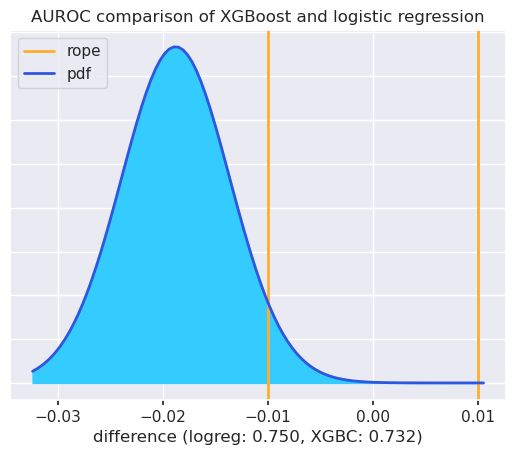

In [11]:
# statistical test comparing performance
xgbc_vs_logreg = two_on_single(x=logreg_results["test_roc_auc"], y=xgbc_results["test_roc_auc"], 
                                rope=0.01, runs=10, names=('logreg', 'XGBC'), plot=True)
plt.title("AUROC comparison of XGBoost and logistic regression")
print(xgbc_vs_logreg)

## si_bin

In [12]:
# define target
target = data['si_bin']

### Logistic regression model

In [13]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [14]:
# define algorithm
logreg = LogisticRegression(class_weight='balanced', random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, logreg)

In [15]:
pipeline.set_params(logisticregression__C=0.01)

# get results from tuned model
logreg_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_accuracy"].mean():.3f} +/- {logreg_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{logreg_results["test_precision"].mean():.3f} +/- {logreg_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{logreg_results["test_recall"].mean():.3f} +/- {logreg_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.707 +/- 0.026
The mean precision with cross-validation is: 0.912 +/- 0.020
The mean recall with cross-validation is: 0.708 +/- 0.030
The mean AUROC with cross-validation is: 0.759 +/- 0.040


### XGBoost model

In [16]:
# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

# define algorithm
class_weighting = target.value_counts()[0] / target.value_counts()[1]
xgbc = XGBClassifier(learning_rate=0.1, n_jobs=2, scale_pos_weight=class_weighting, random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, xgbc)

In [17]:
# hyperparameter values to try
param_grid =  {
    'xgbclassifier__max_leaves': [4, 8, 16, 32, 64, 128],
    'xgbclassifier__reg_lambda': [0.1, 0.5, 1, 2, 5, 10],
    'xgbclassifier__n_estimators': [50, 100, 200, 300]}

randomized_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=500, scoring='roc_auc', n_jobs=2)

cv_results = cross_validate(randomized_search, features, target, n_jobs=2, return_estimator=True)

In [18]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with AUROC of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'xgbclassifier__reg_lambda': 10, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__max_leaves': 4}
with AUROC of 0.719
Best hyperparameters for split #2:
{'xgbclassifier__reg_lambda': 10, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__max_leaves': 4}
with AUROC of 0.762
Best hyperparameters for split #3:
{'xgbclassifier__reg_lambda': 10, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__max_leaves': 4}
with AUROC of 0.799
Best hyperparameters for split #4:
{'xgbclassifier__reg_lambda': 0.5, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__max_leaves': 4}
with AUROC of 0.746
Best hyperparameters for split #5:
{'xgbclassifier__reg_lambda': 10, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__max_leaves': 4}
with AUROC of 0.780


In [19]:
# set hyperparameters from tuning
pipeline.set_params(xgbclassifier__max_leaves=4)
pipeline.set_params(xgbclassifier__reg_lambda=10)
pipeline.set_params(xgbclassifier__n_estimators=50)

# get results from tuned model
xgbc_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{xgbc_results["test_accuracy"].mean():.3f} +/- {xgbc_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{xgbc_results["test_precision"].mean():.3f} +/- {xgbc_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{xgbc_results["test_recall"].mean():.3f} +/- {xgbc_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{xgbc_results["test_roc_auc"].mean():.3f} +/- {xgbc_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.741 +/- 0.025
The mean precision with cross-validation is: 0.899 +/- 0.017
The mean recall with cross-validation is: 0.767 +/- 0.031
The mean AUROC with cross-validation is: 0.761 +/- 0.041


((0.07164506000366067, 0.7636640708789262, 0.16469086911741315), <Figure size 640x480 with 1 Axes>)


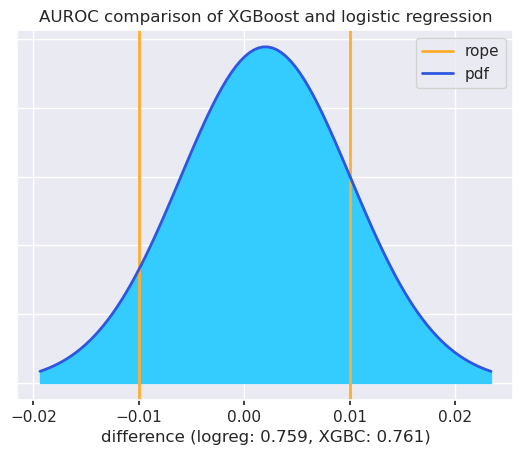

In [20]:
# statistical test comparing performance
xgbc_vs_logreg = two_on_single(x=logreg_results["test_roc_auc"], y=xgbc_results["test_roc_auc"], 
                                rope=0.01, runs=10, names=('logreg', 'XGBC'), plot=True)
plt.title("AUROC comparison of XGBoost and logistic regression")
print(xgbc_vs_logreg)

## attempt_bin

In [21]:
# define target
target = data['attempt_bin']

### Logistic regression model

In [22]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [23]:
# define algorithm
logreg = LogisticRegression(class_weight='balanced', random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, logreg)

In [24]:
pipeline.set_params(logisticregression__C=0.01)

# get results from tuned model
logreg_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_accuracy"].mean():.3f} +/- {logreg_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{logreg_results["test_precision"].mean():.3f} +/- {logreg_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{logreg_results["test_recall"].mean():.3f} +/- {logreg_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.696 +/- 0.024
The mean precision with cross-validation is: 0.519 +/- 0.029
The mean recall with cross-validation is: 0.705 +/- 0.045
The mean AUROC with cross-validation is: 0.762 +/- 0.028


### XGBoost model

In [25]:
# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

# define algorithm
class_weighting = target.value_counts()[0] / target.value_counts()[1]
xgbc = XGBClassifier(learning_rate=0.1, n_jobs=2, scale_pos_weight=class_weighting, random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, xgbc)

In [26]:
# hyperparameter values to try
param_grid =  {
    'xgbclassifier__max_leaves': [4, 8, 16, 32, 64, 128],
    'xgbclassifier__reg_lambda': [0.1, 0.5, 1, 2, 5, 10],
    'xgbclassifier__n_estimators': [50, 100, 200, 300]}

randomized_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=500, scoring='roc_auc', n_jobs=2)

cv_results = cross_validate(randomized_search, features, target, n_jobs=2, return_estimator=True)

In [27]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with AUROC of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'xgbclassifier__reg_lambda': 10, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__max_leaves': 4}
with AUROC of 0.726
Best hyperparameters for split #2:
{'xgbclassifier__reg_lambda': 10, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__max_leaves': 4}
with AUROC of 0.778
Best hyperparameters for split #3:
{'xgbclassifier__reg_lambda': 10, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__max_leaves': 4}
with AUROC of 0.796
Best hyperparameters for split #4:
{'xgbclassifier__reg_lambda': 10, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__max_leaves': 4}
with AUROC of 0.738
Best hyperparameters for split #5:
{'xgbclassifier__reg_lambda': 5, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__max_leaves': 4}
with AUROC of 0.735


In [28]:
# set hyperparameters from tuning
pipeline.set_params(xgbclassifier__max_leaves=4)
pipeline.set_params(xgbclassifier__reg_lambda=10)
pipeline.set_params(xgbclassifier__n_estimators=50)

# get results from tuned model
xgbc_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{xgbc_results["test_accuracy"].mean():.3f} +/- {xgbc_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{xgbc_results["test_precision"].mean():.3f} +/- {xgbc_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{xgbc_results["test_recall"].mean():.3f} +/- {xgbc_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{xgbc_results["test_roc_auc"].mean():.3f} +/- {xgbc_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.694 +/- 0.028
The mean precision with cross-validation is: 0.518 +/- 0.035
The mean recall with cross-validation is: 0.638 +/- 0.051
The mean AUROC with cross-validation is: 0.748 +/- 0.028


((0.7790610135831171, 0.22093811422122622, 8.721956566981603e-07), <Figure size 640x480 with 1 Axes>)


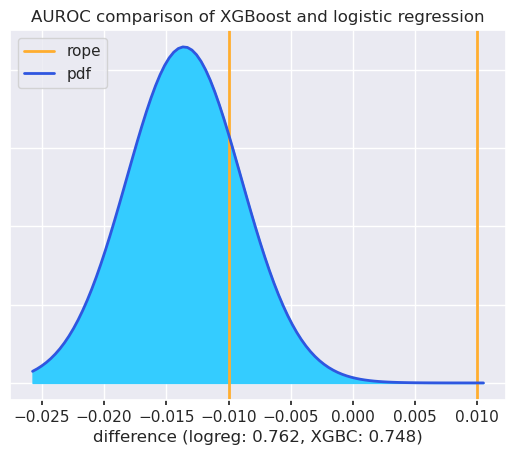

In [29]:
# statistical test comparing performance
xgbc_vs_logreg = two_on_single(x=logreg_results["test_roc_auc"], y=xgbc_results["test_roc_auc"], 
                                rope=0.01, runs=10, names=('logreg', 'XGBC'), plot=True)
plt.title("AUROC comparison of XGBoost and logistic regression")
print(xgbc_vs_logreg)

## nssi_year

In [30]:
# drop records missing nssi_year for nssi_year models
nssi_year_data = data.dropna(subset='nssi_year')

# confirm new size of data set
nssi_year_data.shape

(2401, 18)

In [31]:
# define target
target = nssi_year_data['nssi_year']

# define features
features = nssi_year_data[['loneliness', 'depression', 'sex', 'gender', 'orientation', 'behav_act',
                   'hope', 'hopelessness', 'child_adverse', 'peer_vict', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define imputer
imputer = KNNImputer(n_neighbors=5)

# define cross validation procedure
cross_val = RepeatedKFold(n_splits=10, n_repeats=10, random_state=0)

### Poisson regression model

In [32]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [33]:
# define algorithm
poisson = PoissonRegressor()

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, poisson)

In [34]:
pipeline.set_params(poissonregressor__alpha=5)

# get results from tuned model
poisson_results = cross_validate(pipeline, features, target, 
                                scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                                cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-poisson_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {poisson_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-poisson_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {poisson_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 89.900 +/- 24.933
The mean Poisson deviance with cross-validation is: 76.709 +/- 22.437


### XGBoost model

In [36]:
# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

# define algorithm
xgbr = XGBRegressor(learning_rate=0.1, objective='count:poisson', n_jobs=2, random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, xgbr)

In [37]:
# hyperparameter values to try
param_grid =  {
    'xgbregressor__max_leaves': [4, 8, 16, 32, 64, 128],
    'xgbregressor__reg_lambda': [0.1, 0.5, 1, 2, 5, 10],
    'xgbregressor__n_estimators': [50, 100, 200, 300]}

randomized_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=500, 
                                       scoring='neg_mean_poisson_deviance', n_jobs=2)

cv_results = cross_validate(randomized_search, features, target, n_jobs=2, return_estimator=True)

In [38]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with Poisson deviance of {-cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'xgbregressor__reg_lambda': 10, 'xgbregressor__n_estimators': 100, 'xgbregressor__max_leaves': 4}
with Poisson deviance of 73.656
Best hyperparameters for split #2:
{'xgbregressor__reg_lambda': 10, 'xgbregressor__n_estimators': 100, 'xgbregressor__max_leaves': 4}
with Poisson deviance of 119.083
Best hyperparameters for split #3:
{'xgbregressor__reg_lambda': 1, 'xgbregressor__n_estimators': 100, 'xgbregressor__max_leaves': 4}
with Poisson deviance of 84.944
Best hyperparameters for split #4:
{'xgbregressor__reg_lambda': 1, 'xgbregressor__n_estimators': 100, 'xgbregressor__max_leaves': 4}
with Poisson deviance of 108.066
Best hyperparameters for split #5:
{'xgbregressor__reg_lambda': 0.5, 'xgbregressor__n_estimators': 100, 'xgbregressor__max_leaves': 4}
with Poisson deviance of 49.811


In [39]:
# set hyperparameters from tuning
pipeline.set_params(xgbregressor__max_leaves=4)
pipeline.set_params(xgbregressor__reg_lambda=1)
pipeline.set_params(xgbregressor__n_estimators=100)

# get results from tuned model
xgbr_results = cross_validate(pipeline, features, target, 
                              scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                              cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-xgbr_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {xgbr_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-xgbr_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {xgbr_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 92.121 +/- 25.192
The mean Poisson deviance with cross-validation is: 84.320 +/- 26.539


((0.00019222658578979063, 0.016952301543220027, 0.9828554718709902), <Figure size 640x480 with 1 Axes>)


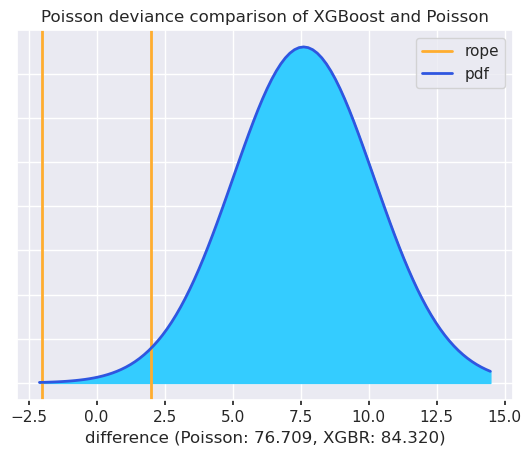

In [40]:
# statistical test comparing performance
xgbr_vs_poisson = two_on_single(x=-poisson_results["test_neg_mean_poisson_deviance"], 
                                y=-xgbr_results["test_neg_mean_poisson_deviance"], 
                                rope=2, runs=10, names=('Poisson', 'XGBR'), plot=True)
plt.title("Poisson deviance comparison of XGBoost and Poisson")
print(xgbr_vs_poisson)

## si_year

In [41]:
# drop records missing si_year for si_year models
si_year_data = data.dropna(subset='si_year')

# confirm new size of data set
si_year_data.shape

(2415, 18)

In [42]:
# define target
target = si_year_data['si_year']

# define features
features = si_year_data[['loneliness', 'depression', 'sex', 'gender', 'orientation', 'behav_act',
                   'hope', 'hopelessness', 'child_adverse', 'peer_vict', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

### Poisson regression model

In [43]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [44]:
# define algorithm
poisson = PoissonRegressor()

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, poisson)

In [45]:
pipeline.set_params(poissonregressor__alpha=10)

# get results from tuned model
poisson_results = cross_validate(pipeline, features, target, 
                                scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                                cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-poisson_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {poisson_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-poisson_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {poisson_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 145.912 +/- 18.975
The mean Poisson deviance with cross-validation is: 135.696 +/- 21.025


### XGBoost model

In [46]:
# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

# define algorithm
xgbr = XGBRegressor(learning_rate=0.1, objective='count:poisson', n_jobs=2, random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, xgbr)

In [47]:
# hyperparameter values to try
param_grid =  {
    'xgbregressor__max_leaves': [4, 8, 16, 32, 64, 128],
    'xgbregressor__reg_lambda': [0.1, 0.5, 1, 2, 5, 10],
    'xgbregressor__n_estimators': [50, 100, 200, 300]}

randomized_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=500, 
                                       scoring='neg_mean_poisson_deviance', n_jobs=2)

cv_results = cross_validate(randomized_search, features, target, n_jobs=2, return_estimator=True)

In [48]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with Poisson deviance of {-cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'xgbregressor__reg_lambda': 2, 'xgbregressor__n_estimators': 100, 'xgbregressor__max_leaves': 4}
with Poisson deviance of 134.480
Best hyperparameters for split #2:
{'xgbregressor__reg_lambda': 5, 'xgbregressor__n_estimators': 100, 'xgbregressor__max_leaves': 4}
with Poisson deviance of 180.833
Best hyperparameters for split #3:
{'xgbregressor__reg_lambda': 2, 'xgbregressor__n_estimators': 100, 'xgbregressor__max_leaves': 4}
with Poisson deviance of 157.791
Best hyperparameters for split #4:
{'xgbregressor__reg_lambda': 10, 'xgbregressor__n_estimators': 100, 'xgbregressor__max_leaves': 4}
with Poisson deviance of 166.180
Best hyperparameters for split #5:
{'xgbregressor__reg_lambda': 0.5, 'xgbregressor__n_estimators': 100, 'xgbregressor__max_leaves': 4}
with Poisson deviance of 136.123


In [49]:
# set hyperparameters from tuning
pipeline.set_params(xgbregressor__max_leaves=4)
pipeline.set_params(xgbregressor__reg_lambda=2)
pipeline.set_params(xgbregressor__n_estimators=100)

# get results from tuned model
xgbr_results = cross_validate(pipeline, features, target, 
                              scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                              cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-xgbr_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {xgbr_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-xgbr_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {xgbr_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 149.610 +/- 20.243
The mean Poisson deviance with cross-validation is: 153.404 +/- 28.682


((3.057825932770208e-06, 0.00011789063640887942, 0.9998790515376583), <Figure size 640x480 with 1 Axes>)


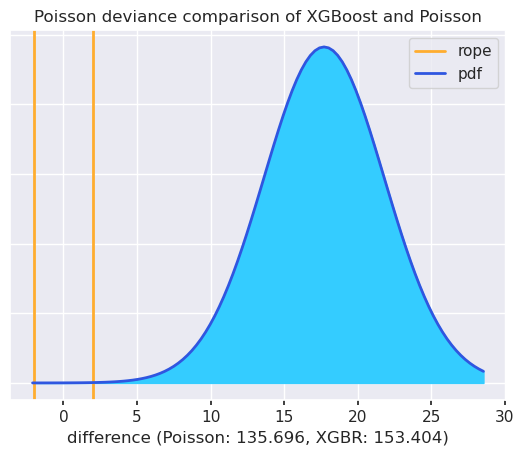

In [50]:
# statistical test comparing performance
xgbr_vs_poisson = two_on_single(x=-poisson_results["test_neg_mean_poisson_deviance"], 
                                y=-xgbr_results["test_neg_mean_poisson_deviance"], 
                                rope=2, runs=10, names=('Poisson', 'XGBR'), plot=True)
plt.title("Poisson deviance comparison of XGBoost and Poisson")
print(xgbr_vs_poisson)

## attempt_year

In [51]:
# drop records missing attempt_year for attempt_year models
attempt_year_data = data.dropna(subset='attempt_year')

# confirm new size of data set
attempt_year_data.shape

(2442, 18)

In [52]:
# define target
target = attempt_year_data['attempt_year']

# define features
features = attempt_year_data[['loneliness', 'depression', 'sex', 'gender', 'orientation', 'behav_act',
                   'hope', 'hopelessness', 'child_adverse', 'peer_vict', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

### Poisson regression model

In [53]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [54]:
# define algorithm
poisson = PoissonRegressor()

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, poisson)

In [55]:
pipeline.set_params(poissonregressor__alpha=0.2)

# get results from tuned model
poisson_results = cross_validate(pipeline, features, target, 
                                scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                                cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-poisson_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {poisson_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-poisson_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {poisson_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 2.008 +/- 0.730
The mean Poisson deviance with cross-validation is: 1.873 +/- 0.451


### XGBoost model

In [56]:
# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

# define algorithm
xgbr = XGBRegressor(learning_rate=0.1, objective='count:poisson', n_jobs=2, random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, xgbr)

In [57]:
# hyperparameter values to try
param_grid =  {
    'xgbregressor__max_leaves': [4, 8, 16, 32, 64, 128],
    'xgbregressor__reg_lambda': [0.1, 0.5, 1, 2, 5, 10],
    'xgbregressor__n_estimators': [50, 100, 200, 300]}

randomized_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=500, 
                                       scoring='neg_mean_poisson_deviance', n_jobs=2)

cv_results = cross_validate(randomized_search, features, target, n_jobs=2, return_estimator=True)

In [58]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with Poisson deviance of {-cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'xgbregressor__reg_lambda': 0.1, 'xgbregressor__n_estimators': 50, 'xgbregressor__max_leaves': 4}
with Poisson deviance of 1.590
Best hyperparameters for split #2:
{'xgbregressor__reg_lambda': 10, 'xgbregressor__n_estimators': 50, 'xgbregressor__max_leaves': 4}
with Poisson deviance of 2.639
Best hyperparameters for split #3:
{'xgbregressor__reg_lambda': 2, 'xgbregressor__n_estimators': 50, 'xgbregressor__max_leaves': 4}
with Poisson deviance of 1.894
Best hyperparameters for split #4:
{'xgbregressor__reg_lambda': 10, 'xgbregressor__n_estimators': 50, 'xgbregressor__max_leaves': 4}
with Poisson deviance of 1.905
Best hyperparameters for split #5:
{'xgbregressor__reg_lambda': 10, 'xgbregressor__n_estimators': 50, 'xgbregressor__max_leaves': 4}
with Poisson deviance of 1.886


In [59]:
# set hyperparameters from tuning
pipeline.set_params(xgbregressor__max_leaves=4)
pipeline.set_params(xgbregressor__reg_lambda=10)
pipeline.set_params(xgbregressor__n_estimators=50)

# get results from tuned model
xgbr_results = cross_validate(pipeline, features, target, 
                              scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                              cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-xgbr_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {xgbr_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-xgbr_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {xgbr_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 2.064 +/- 0.747
The mean Poisson deviance with cross-validation is: 2.022 +/- 0.544


((6.030314141347973e-64, 1.0, 0.0), <Figure size 640x480 with 1 Axes>)


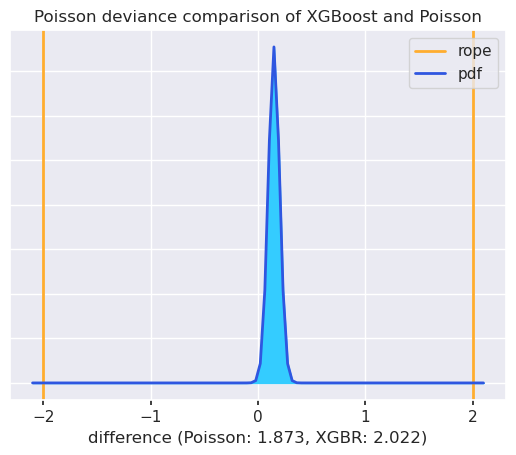

In [60]:
# statistical test comparing performance
xgbr_vs_poisson = two_on_single(x=-poisson_results["test_neg_mean_poisson_deviance"], 
                                y=-xgbr_results["test_neg_mean_poisson_deviance"], 
                                rope=2, runs=10, names=('Poisson', 'XGBR'), plot=True)
plt.title("Poisson deviance comparison of XGBoost and Poisson")
print(xgbr_vs_poisson)

## Summary

XGBoost did not outperform the scikit-learn models we tested.  
Performance of the XGBoost models was either comparable or worse compared to the best performing scikit-learn models.

# Sexual Orientation in Sexual Minority Group

In [61]:
# drop features to reduce multicollinearity
data.drop(labels=['hopelessness', 'peer_vict', 'behav_act'], axis=1, inplace=True)

In [62]:
# define function to compute permutation feature importances
# perm_n: number of iterations of permutation feature importance procedure to aggregate
def perm_feat_imp(pipeline, perm_n=25, score='roc_auc'):
    
    # create dataframe to store results
    perm_results_df = pd.DataFrame(index=features.columns, columns=range(perm_n), dtype='float64')
    
    for i in range(perm_n):

        # split data for permutation importance computation
        X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

        # permutation importance computation
        pipeline.fit(X_train, y_train)
        perm_results = permutation_importance(pipeline, X_test, y_test, scoring=score, 
                                              n_repeats=10, random_state=0, n_jobs=2)

        # store results in a dataframe and sort
        perm_results_df.iloc[:, i] = perm_results.importances_mean
        
    # summarize results over iterations
    perm_results_summary = pd.DataFrame(index=features.columns)
    perm_results_summary['mean'] = perm_results_df.mean(axis=1)
    perm_results_summary['std'] = perm_results_df.std(axis=1)
    perm_results_summary.sort_values('mean', ascending=False, inplace=True)
    
    return perm_results_df, perm_results_summary

In [63]:
# define function to compute feature rank instability
# how much feature rank changes over aggregations of successively larger number of permutation importance iterations
def rank_instability(perm_results_df):
    instability = pd.Series(index=range(2,26), dtype='float')
    
    # compute feature rank instability between 1st iteration and the aggregation of the 1st 2 iterations
    agg1 = perm_results_df.iloc[:, 0].rank(ascending=False)
    agg2 = perm_results_df.iloc[:, 0:2].mean(axis=1).rank(ascending=False)
    instability[2] = abs(agg2 - agg1).mean()
    
    # compute feature rank instability between successive aggregations
    for i in range(3,26):
        agg1 = perm_results_df.iloc[:, 0:(i-1)].mean(axis=1).rank(ascending=False)
        agg2 = perm_results_df.iloc[:, 0:i].mean(axis=1).rank(ascending=False)
        instability[i] = abs(agg2 - agg1).mean()
        
    return instability

In [64]:
# create subset of data for orientation minority group
data_minor = data[data['orientation'] != 'Heterosexual/Straight'].copy()

## nssi_bin

In [65]:
# define target
target = data_minor['nssi_bin']

# define features
features = data_minor[['loneliness', 'depression', 'sex', 'gender',
                   'orientation', 'hope', 'child_adverse', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define imputer
imputer = KNNImputer(n_neighbors=5)

# define cross validation procedure
cross_val = StratifiedKFold(n_splits=5)

In [66]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [67]:
# define algorithm
logreg = LogisticRegression(class_weight='balanced', random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, logreg)

In [68]:
# set C to 0.1
pipeline.set_params(logisticregression__C=0.1)

# get results from tuned model
logreg_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_accuracy"].mean():.3f} +/- {logreg_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{logreg_results["test_precision"].mean():.3f} +/- {logreg_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{logreg_results["test_recall"].mean():.3f} +/- {logreg_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.670 +/- 0.010
The mean precision with cross-validation is: 0.841 +/- 0.007
The mean recall with cross-validation is: 0.675 +/- 0.019
The mean AUROC with cross-validation is: 0.725 +/- 0.015


                    mean       std
depression      0.044743  0.013833
sex             0.022337  0.008704
discrimination  0.018180  0.007364
child_adverse   0.016135  0.006747
gender          0.013907  0.006741
orientation     0.009923  0.004757
anxiety         0.006820  0.004959
hope            0.001571  0.003400
loneliness     -0.000005  0.001243


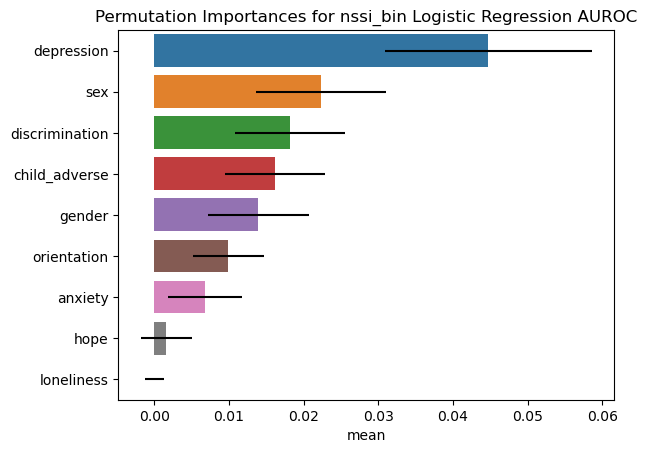

In [69]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline)

# view results
print(perm_results_summary)
plt.title("Permutation Importances for nssi_bin Logistic Regression AUROC")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

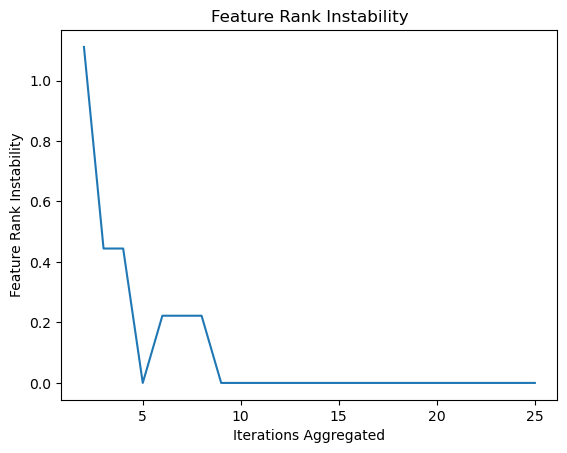

In [70]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

## si_bin

In [71]:
# define target
target = data_minor['si_bin']

In [72]:
# get results from tuned model
logreg_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_accuracy"].mean():.3f} +/- {logreg_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{logreg_results["test_precision"].mean():.3f} +/- {logreg_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{logreg_results["test_recall"].mean():.3f} +/- {logreg_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.672 +/- 0.014
The mean precision with cross-validation is: 0.917 +/- 0.016
The mean recall with cross-validation is: 0.677 +/- 0.013
The mean AUROC with cross-validation is: 0.696 +/- 0.042


                    mean       std
depression      0.106356  0.027429
child_adverse   0.035384  0.012277
gender          0.006073  0.004334
loneliness      0.005378  0.003254
anxiety         0.004419  0.003904
sex             0.000898  0.003585
orientation    -0.000683  0.007452
hope           -0.000836  0.003545
discrimination -0.001231  0.002421


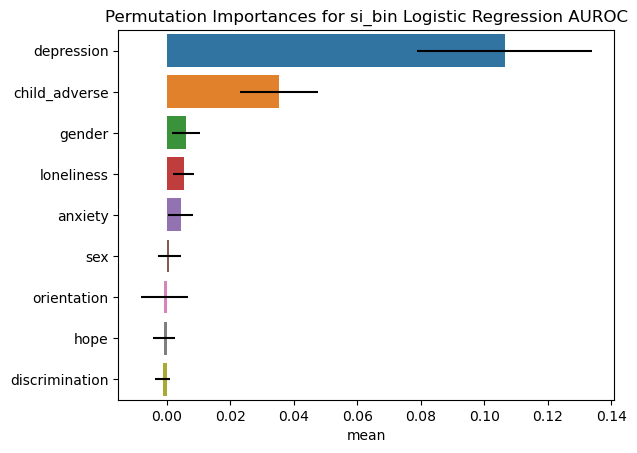

In [73]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline)

# view results
print(perm_results_summary)
plt.title("Permutation Importances for si_bin Logistic Regression AUROC")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

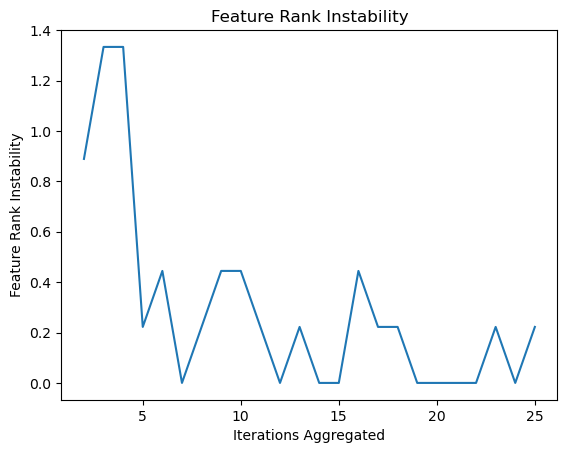

In [74]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

## attempt_bin

In [75]:
# define target
target = data_minor['attempt_bin']

In [76]:
# get results from tuned model
logreg_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_accuracy"].mean():.3f} +/- {logreg_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{logreg_results["test_precision"].mean():.3f} +/- {logreg_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{logreg_results["test_recall"].mean():.3f} +/- {logreg_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.671 +/- 0.014
The mean precision with cross-validation is: 0.529 +/- 0.017
The mean recall with cross-validation is: 0.678 +/- 0.024
The mean AUROC with cross-validation is: 0.736 +/- 0.020


                    mean       std
depression      0.072143  0.013446
discrimination  0.046091  0.010476
child_adverse   0.031084  0.008675
hope            0.002815  0.002225
orientation     0.002409  0.004657
sex             0.002181  0.002569
gender          0.002012  0.003199
anxiety         0.000370  0.001771
loneliness     -0.000880  0.001783


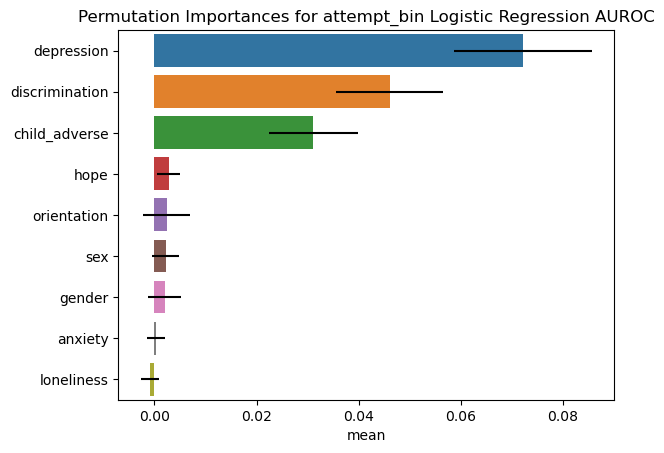

In [77]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline)

# view results
print(perm_results_summary)
plt.title("Permutation Importances for attempt_bin Logistic Regression AUROC")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

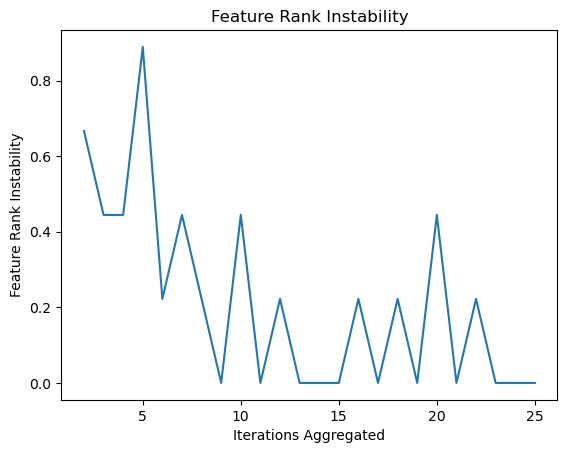

In [78]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

## nssi_year

In [79]:
# drop records missing nssi_year for nssi_year models
nssi_year_data = data.dropna(subset='nssi_year')

# create subset of data for orientation minority group
data_minor = nssi_year_data[nssi_year_data['orientation'] != 'Heterosexual/Straight'].copy()

In [80]:
# define target
target = data_minor['nssi_year']

# define features
features = data_minor[['loneliness', 'depression', 'sex', 'gender',
                   'orientation', 'hope', 'child_adverse', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define imputer
imputer = KNNImputer(n_neighbors=5)

# define cross validation procedure
cross_val = KFold(n_splits=5)

In [81]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [82]:
# define algorithm
poisson = PoissonRegressor()

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, poisson)

In [83]:
pipeline.set_params(poissonregressor__alpha=5)

# get results from tuned model
poisson_results = cross_validate(pipeline, features, target, 
                                scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                                cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-poisson_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {poisson_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-poisson_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {poisson_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 98.397 +/- 25.974
The mean Poisson deviance with cross-validation is: 88.645 +/- 25.455


                     mean       std
depression      11.897105  4.299100
discrimination   2.539931  1.884753
anxiety          2.438457  1.681638
gender           2.199700  1.143960
sex              0.492540  0.573519
orientation      0.334175  0.635195
child_adverse    0.070447  0.643443
loneliness      -0.125526  0.542098
hope            -0.164454  0.661723


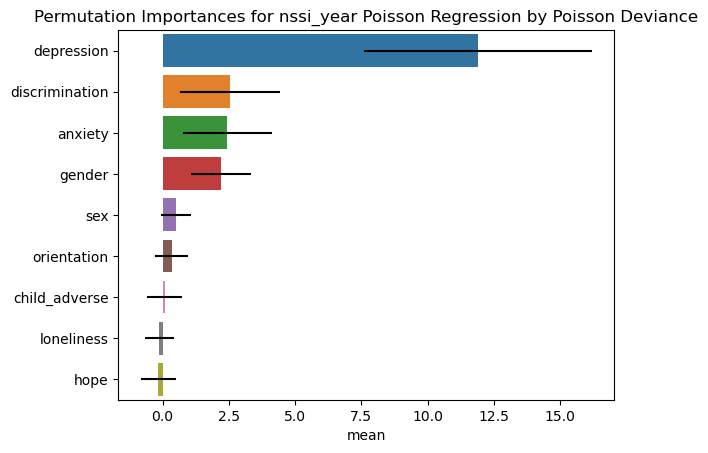

In [84]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline, score='neg_mean_poisson_deviance')

# view results
print(perm_results_summary)
plt.title("Permutation Importances for nssi_year Poisson Regression by Poisson Deviance")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

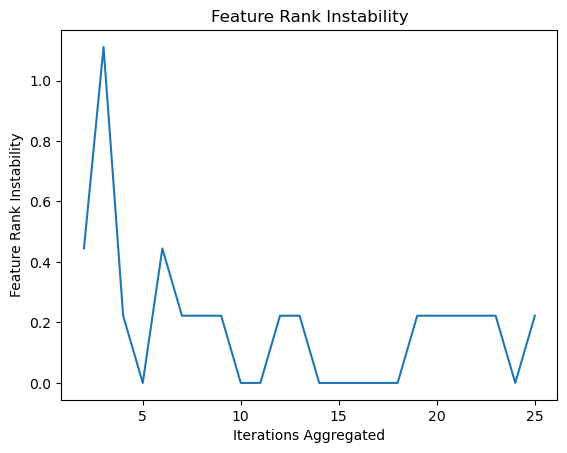

In [85]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

## si_year

In [86]:
# drop records missing si_year for si_year models
si_year_data = data.dropna(subset='si_year')

# create subset of data for orientation minority group
data_minor = si_year_data[si_year_data['orientation'] != 'Heterosexual/Straight'].copy()

In [87]:
# define target
target = data_minor['si_year']

# define features
features = data_minor[['loneliness', 'depression', 'sex', 'gender',
                   'orientation', 'hope', 'child_adverse', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

In [88]:
# get results from tuned model
poisson_results = cross_validate(pipeline, features, target, 
                                scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                                cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-poisson_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {poisson_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-poisson_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {poisson_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 154.088 +/- 18.087
The mean Poisson deviance with cross-validation is: 148.545 +/- 19.731


                     mean       std
depression      26.731362  5.324431
anxiety          8.291037  2.928605
loneliness       1.856011  1.179837
child_adverse    1.571195  1.816329
discrimination   0.822075  1.240176
hope             0.115963  0.839471
orientation      0.054406  1.494163
sex             -0.127620  0.367423
gender          -0.230580  0.626700


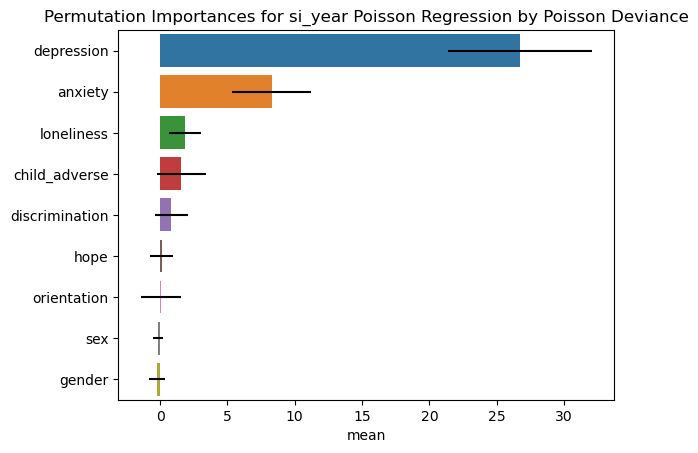

In [89]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline, score='neg_mean_poisson_deviance')

# view results
print(perm_results_summary)
plt.title("Permutation Importances for si_year Poisson Regression by Poisson Deviance")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

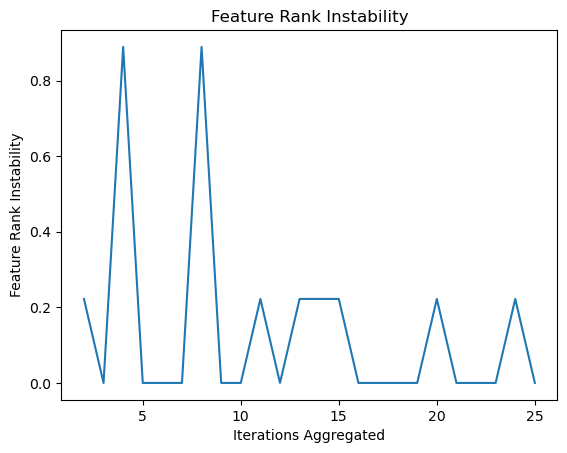

In [90]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

## Summary

The feature importance of orientation was only reliably greater than 0 for nssi_bin,  
and even in that case, its feature importance ranking was only 6th out of 9 features.